# Auto encoders 

Author: Gabriel Rodrigues Palma

additional source: DataCamp and MIT introduction to Deep Learning

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
with tf.device('/GPU'):
    a = tf.random.normal(shape=(2,), dtype=tf.float32)
    b = tf.nn.relu(a)

Metal device set to: Apple M1


2022-07-07 12:23:00.772930: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-07 12:23:00.773627: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Loading the packages

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale

In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

## Loading the data and visualizing it

In [6]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

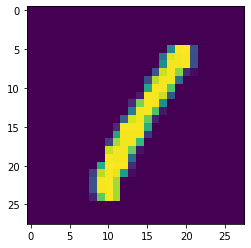

In [7]:
plt.imshow(x_train[3, :, :])

In [9]:
reshaped_x_train = x_train.reshape(60000, 28 *28)
reshaped_x_train.shape
reshaped_x_test = x_test.reshape(10000, 28 *28)
reshaped_x_test.shape

(10000, 784)

## Creating important fnuctions

In [10]:
def show_encodings(encoded_imgs,number=1):
    n = 5  # how many digits we will display
    original = reshaped_x_test
    original = original[np.where(y_test == number)]
    encoded_imgs = encoded_imgs[np.where(y_test==number)]
    plt.figure(figsize=(20, 4))
    #plt.title('Original '+str(number)+' vs Encoded representation')
    for i in range(min(n,len(original))):
        # display original imgs
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display encoded imgs
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(np.tile(encoded_imgs[i],(32,1)))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
def compare_plot(original,decoded_imgs):
    n = 4  # How many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.title('Real vs Decoded images')
    plt.show()

In [11]:
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

In [12]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

## Implementing auto encoders with MNIST data

In [13]:
# Start with a sequential model
autoencoder = Sequential()

# Add a dense layer with input the original image pixels and neurons the encoded representation
autoencoder.add(Dense(32, input_shape=(784, ), activation="relu"))

# Add an output layer with as many neurons as the orginal image pixels
autoencoder.add(Dense(784, activation = "sigmoid"))

# Compile your model with adadelta
autoencoder.compile(optimizer = 'adadelta', loss = 'binary_crossentropy', metrics = 'accuracy')

# Summarize your model structure
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                25120     
                                                                 
 dense_1 (Dense)             (None, 784)               25872     
                                                                 
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [14]:
reshaped_x_train.shape

(60000, 784)

In [15]:
# training the model
autoencoder.fit(reshaped_x_test, reshaped_x_test, epochs=1000)

Epoch 1/1000


2022-07-07 12:23:30.974277: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-07 12:23:31.180760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 2s 4ms/step - loss: 0.6948 - accuracy: 6.0000e-04
Epoch 2/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.6945 - accuracy: 6.0000e-04
Epoch 3/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.6942 - accuracy: 6.0000e-04
Epoch 4/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.6939 - accuracy: 6.0000e-04
Epoch 5/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.6936 - accuracy: 6.0000e-04
Epoch 6/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.6934 - accuracy: 6.0000e-04
Epoch 7/1000
313/313 [==============================] - 1s 5ms/step - loss: 0.6931 - accuracy: 5.0000e-04
Epoch 8/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.6928 - accuracy: 5.0000e-04
Epoch 9/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.6925 - accuracy: 5.0000e-04
Epoch 10/1000
313/313 [==============================] - 1s

313/313 [==============================] - 1s 4ms/step - loss: 0.6383 - accuracy: 0.0033
Epoch 80/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.6363 - accuracy: 0.0034
Epoch 81/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.6342 - accuracy: 0.0034
Epoch 82/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.6321 - accuracy: 0.0034
Epoch 83/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.6298 - accuracy: 0.0035
Epoch 84/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.6276 - accuracy: 0.0037
Epoch 85/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.6252 - accuracy: 0.0038
Epoch 86/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.6228 - accuracy: 0.0039
Epoch 87/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.6203 - accuracy: 0.0039
Epoch 88/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.6178 - a

313/313 [==============================] - 1s 4ms/step - loss: 0.3833 - accuracy: 0.0052
Epoch 159/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.3809 - accuracy: 0.0051
Epoch 160/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.3787 - accuracy: 0.0051
Epoch 161/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.3764 - accuracy: 0.0052
Epoch 162/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.3743 - accuracy: 0.0052
Epoch 163/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.3721 - accuracy: 0.0052
Epoch 164/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.3701 - accuracy: 0.0052
Epoch 165/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.3681 - accuracy: 0.0054
Epoch 166/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.3661 - accuracy: 0.0053
Epoch 167/1000
313/313 [==============================] - 1s 4ms/step - loss: 0

313/313 [==============================] - 1s 4ms/step - loss: 0.3019 - accuracy: 0.0087
Epoch 237/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.3015 - accuracy: 0.0089
Epoch 238/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.3012 - accuracy: 0.0088
Epoch 239/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.3008 - accuracy: 0.0088
Epoch 240/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.3005 - accuracy: 0.0090
Epoch 241/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.3001 - accuracy: 0.0091
Epoch 242/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2998 - accuracy: 0.0091
Epoch 243/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2995 - accuracy: 0.0092
Epoch 244/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2992 - accuracy: 0.0094
Epoch 245/1000
313/313 [==============================] - 1s 4ms/step - loss: 0

313/313 [==============================] - 1s 4ms/step - loss: 0.2865 - accuracy: 0.0094
Epoch 315/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2864 - accuracy: 0.0094
Epoch 316/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2863 - accuracy: 0.0094
Epoch 317/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2862 - accuracy: 0.0093
Epoch 318/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2861 - accuracy: 0.0093
Epoch 319/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2860 - accuracy: 0.0092
Epoch 320/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2859 - accuracy: 0.0090
Epoch 321/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2858 - accuracy: 0.0091
Epoch 322/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2857 - accuracy: 0.0090
Epoch 323/1000
313/313 [==============================] - 1s 4ms/step - loss: 0

313/313 [==============================] - 1s 4ms/step - loss: 0.2808 - accuracy: 0.0091
Epoch 393/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2807 - accuracy: 0.0091
Epoch 394/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2807 - accuracy: 0.0090
Epoch 395/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2806 - accuracy: 0.0090
Epoch 396/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2806 - accuracy: 0.0090
Epoch 397/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2805 - accuracy: 0.0092
Epoch 398/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2805 - accuracy: 0.0092
Epoch 399/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2804 - accuracy: 0.0091
Epoch 400/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2804 - accuracy: 0.0092
Epoch 401/1000
313/313 [==============================] - 1s 4ms/step - loss: 0

313/313 [==============================] - 1s 4ms/step - loss: 0.2777 - accuracy: 0.0094
Epoch 471/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2776 - accuracy: 0.0094
Epoch 472/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2776 - accuracy: 0.0094
Epoch 473/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2776 - accuracy: 0.0094
Epoch 474/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2775 - accuracy: 0.0094
Epoch 475/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2775 - accuracy: 0.0094
Epoch 476/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2775 - accuracy: 0.0094
Epoch 477/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2774 - accuracy: 0.0094
Epoch 478/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2774 - accuracy: 0.0094
Epoch 479/1000
313/313 [==============================] - 1s 4ms/step - loss: 0

313/313 [==============================] - 1s 4ms/step - loss: 0.2755 - accuracy: 0.0099
Epoch 549/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2755 - accuracy: 0.0100
Epoch 550/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2755 - accuracy: 0.0100
Epoch 551/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2754 - accuracy: 0.0100
Epoch 552/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2754 - accuracy: 0.0100
Epoch 553/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2754 - accuracy: 0.0099
Epoch 554/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2754 - accuracy: 0.0101
Epoch 555/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2754 - accuracy: 0.0099
Epoch 556/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2753 - accuracy: 0.0100
Epoch 557/1000
313/313 [==============================] - 1s 4ms/step - loss: 0

313/313 [==============================] - 1s 4ms/step - loss: 0.2738 - accuracy: 0.0101
Epoch 627/1000
313/313 [==============================] - 1s 5ms/step - loss: 0.2738 - accuracy: 0.0101
Epoch 628/1000
313/313 [==============================] - 1s 5ms/step - loss: 0.2738 - accuracy: 0.0101
Epoch 629/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2738 - accuracy: 0.0101
Epoch 630/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2738 - accuracy: 0.0101
Epoch 631/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2738 - accuracy: 0.0101
Epoch 632/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2737 - accuracy: 0.0101
Epoch 633/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2737 - accuracy: 0.0101
Epoch 634/1000
313/313 [==============================] - 1s 5ms/step - loss: 0.2737 - accuracy: 0.0101
Epoch 635/1000
313/313 [==============================] - 1s 4ms/step - loss: 0

313/313 [==============================] - 1s 4ms/step - loss: 0.2724 - accuracy: 0.0108
Epoch 705/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2724 - accuracy: 0.0110
Epoch 706/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2724 - accuracy: 0.0110
Epoch 707/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2723 - accuracy: 0.0108
Epoch 708/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2723 - accuracy: 0.0110
Epoch 709/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2723 - accuracy: 0.0108
Epoch 710/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2723 - accuracy: 0.0109
Epoch 711/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2723 - accuracy: 0.0109
Epoch 712/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2723 - accuracy: 0.0109
Epoch 713/1000
313/313 [==============================] - 1s 4ms/step - loss: 0

313/313 [==============================] - 1s 4ms/step - loss: 0.2710 - accuracy: 0.0108
Epoch 783/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2710 - accuracy: 0.0108
Epoch 784/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2710 - accuracy: 0.0108
Epoch 785/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2710 - accuracy: 0.0108
Epoch 786/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2710 - accuracy: 0.0108
Epoch 787/1000
313/313 [==============================] - 2s 5ms/step - loss: 0.2710 - accuracy: 0.0108
Epoch 788/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2709 - accuracy: 0.0108
Epoch 789/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2709 - accuracy: 0.0108
Epoch 790/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2709 - accuracy: 0.0108
Epoch 791/1000
313/313 [==============================] - 1s 4ms/step - loss: 0

313/313 [==============================] - 1s 4ms/step - loss: 0.2697 - accuracy: 0.0110
Epoch 861/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2697 - accuracy: 0.0108
Epoch 862/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2697 - accuracy: 0.0110
Epoch 863/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2697 - accuracy: 0.0110
Epoch 864/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2696 - accuracy: 0.0109
Epoch 865/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2696 - accuracy: 0.0110
Epoch 866/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2696 - accuracy: 0.0110
Epoch 867/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2696 - accuracy: 0.0110
Epoch 868/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2696 - accuracy: 0.0109
Epoch 869/1000
313/313 [==============================] - 1s 4ms/step - loss: 0

313/313 [==============================] - 1s 4ms/step - loss: 0.2683 - accuracy: 0.0113
Epoch 939/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2683 - accuracy: 0.0113
Epoch 940/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2683 - accuracy: 0.0113
Epoch 941/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2683 - accuracy: 0.0113
Epoch 942/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2682 - accuracy: 0.0113
Epoch 943/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2682 - accuracy: 0.0113
Epoch 944/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2682 - accuracy: 0.0113
Epoch 945/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2682 - accuracy: 0.0113
Epoch 946/1000
313/313 [==============================] - 1s 4ms/step - loss: 0.2682 - accuracy: 0.0113
Epoch 947/1000
313/313 [==============================] - 1s 4ms/step - loss: 0

In [65]:
autoencoder.save_weights('autoencoder_weights.h5')

(array([9.831e+03, 1.800e+01, 1.500e+01, 1.900e+01, 1.900e+01, 1.900e+01,
        9.000e+00, 1.000e+01, 1.300e+01, 4.700e+01]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

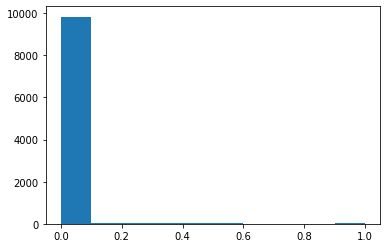

In [30]:
plt.hist(reshaped_x_test[:,200])

In [25]:
decoded_imgs.shape

(10000, 784)

(array([7.517e+03, 1.591e+03, 4.890e+02, 2.240e+02, 8.100e+01, 5.700e+01,
        2.600e+01, 1.000e+01, 1.000e+00, 4.000e+00]),
 array([2.1457037e-05, 1.7033903e-02, 3.4046348e-02, 5.1058795e-02,
        6.8071239e-02, 8.5083686e-02, 1.0209613e-01, 1.1910858e-01,
        1.3612102e-01, 1.5313347e-01, 1.7014591e-01], dtype=float32),
 <BarContainer object of 10 artists>)

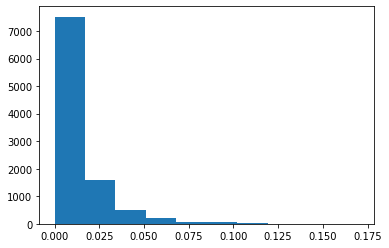

In [31]:
plt.hist(decoded_imgs[:,200])

186/313 [================>.............] - ETA: 0s

2022-06-21 17:00:29.453525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 0s 844us/step


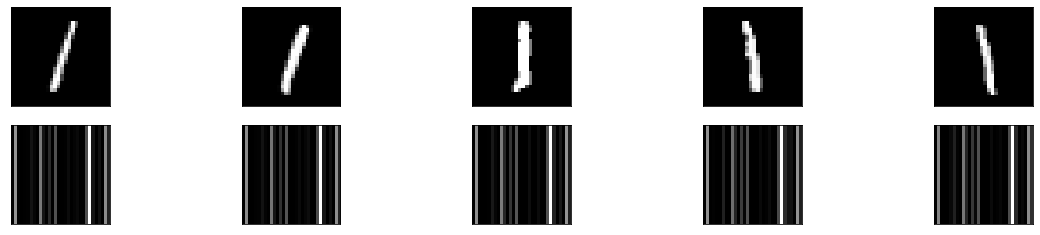

In [17]:
# Build your encoder by using the first layer of your autoencoder
encoder = Sequential()
encoder.add(autoencoder.layers[0])

# Encode the noisy images and show the encodings for your favorite number [0-9]
encodings = encoder.predict(reshaped_x_test)
show_encodings(encodings, number = 1)

313/313 [==============================] - 1s 2ms/step


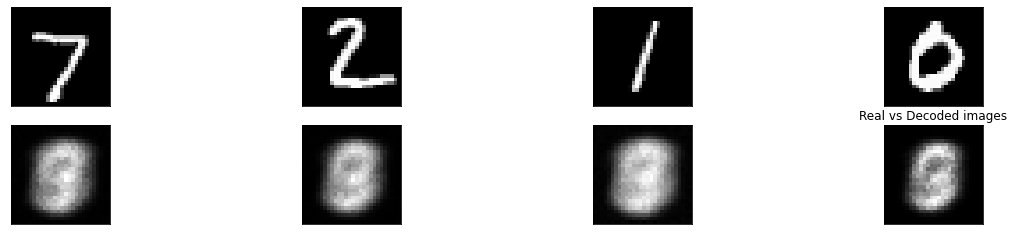

In [17]:
# Predict on the noisy images with your autoencoder
decoded_imgs = autoencoder.predict(reshaped_x_test)

# Plot noisy vs decoded images
compare_plot(reshaped_x_test, decoded_imgs)

105/313 [=========>....................] - ETA: 0s

2022-06-21 17:00:37.889846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 1s 2ms/step


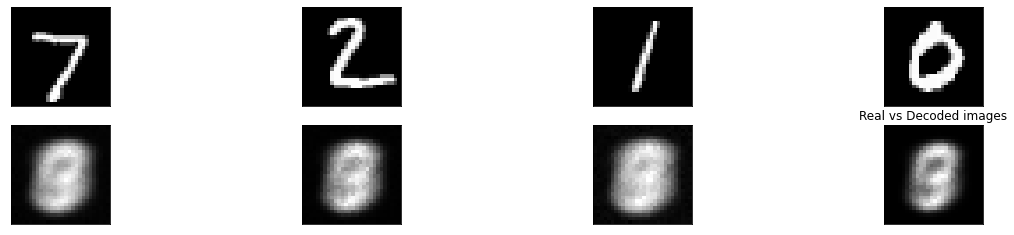

In [18]:
# Predict on the noisy images with your autoencoder
decoded_imgs = autoencoder.predict(reshaped_x_test)

# Plot noisy vs decoded images
compare_plot(reshaped_x_test, decoded_imgs)

# Implementing Variational Auto Encoders with MNIST data

In [9]:
class Sampling(layers.Layer):
    
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Creating the VA autoencoders 

#### Build the encoder

In [10]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

#### Build the decoder

In [11]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

## Define the VAE as a Model with a custom train_step

In [12]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

## Training the models with MNIST data

In [14]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

## Plotting the Latent space

2022-06-02 19:26:16.035366: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


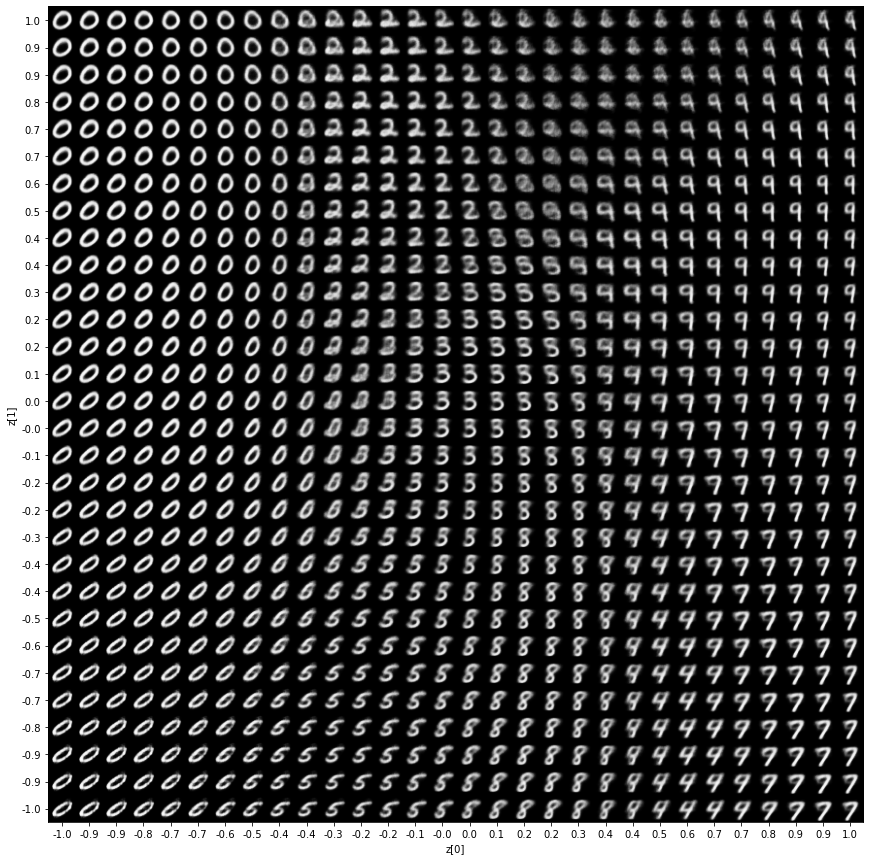

In [77]:
plot_latent_space(vae)

2022-06-02 19:26:43.776990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


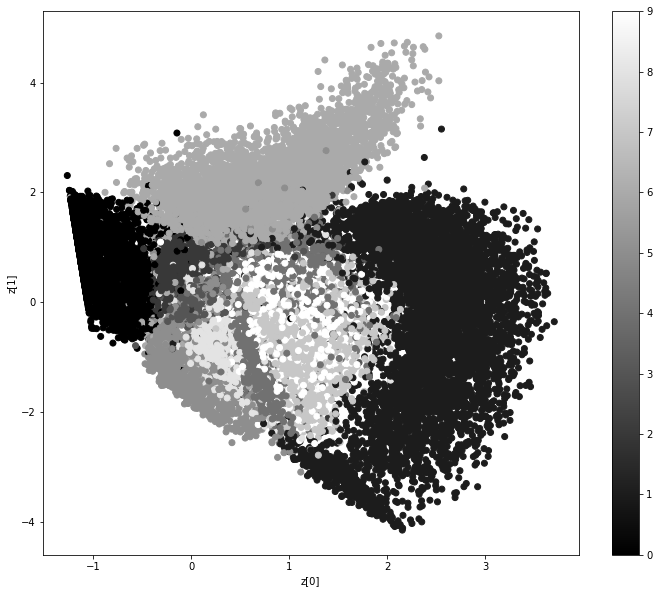

In [78]:
(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

# Undestanding the generation distribution

In [15]:
normal_1 = np.random.normal(loc=0, scale=10, size=1000)
normal_2 = np.random.normal(loc=100, scale=10, size=1000)
normal_3 = np.random.normal(loc=200, scale=10, size=1000)
normal_4 = np.random.normal(loc=300, scale=10, size=1000)
normal_5 = np.random.normal(loc=400, scale=10, size=1000)
normal_6 = np.random.normal(loc=500, scale=10, size=1000)
normal_6.reshape(1000).shape

(1000,)

In [16]:
data = minmax_scale(np.vstack((normal_1, normal_2, normal_3, normal_4, normal_5, normal_6)).transpose())

In [17]:
X_train, X_test, y_train, y_test = train_test_split(data, data, test_size=0.3, random_state=42)

(array([  2.,  13.,  29.,  65., 149., 157., 144.,  82.,  44.,  15.]),
 array([0.        , 0.0946    , 0.1892    , 0.28380001, 0.37840001,
        0.47300001, 0.56760001, 0.66220002, 0.75680002, 0.85140002,
        0.94600002]),
 <BarContainer object of 10 artists>)

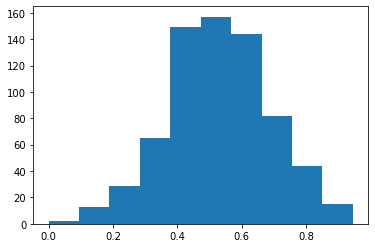

In [18]:
plt.hist(X_train[:, 1])

In [19]:
# Start with a sequential model
autoencoder = Sequential()

# Add a dense layer with input the original image pixels and neurons the encoded representation
autoencoder.add(Dense(3, input_shape=(6, ), activation="relu"))
autoencoder.add(Dense(2, activation="relu"))
autoencoder.add(Dropout(0.5))
autoencoder.add(Dense(2, activation="relu"))
# Add an output layer with as many neurons as the orginal image pixels
autoencoder.add(Dense(6, activation = "softmax"))

# Compile your model with adadelta
autoencoder.compile(optimizer = 'adadelta', loss = 'binary_crossentropy', metrics = 'accuracy')

# Summarize your model structure
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 3)                 21        
                                                                 
 dense_5 (Dense)             (None, 2)                 8         
                                                                 
 dropout (Dropout)           (None, 2)                 0         
                                                                 
 dense_6 (Dense)             (None, 2)                 6         
                                                                 
 dense_7 (Dense)             (None, 6)                 18        
                                                                 
Total params: 53
Trainable params: 53
Non-trainable params: 0
_________________________________________________________________


In [85]:
# training the model
autoencoder.fit(X_train, X_train, epochs=5000)

Epoch 1/5000
 9/22 [===========>..................] - ETA: 0s - loss: 0.7111 - accuracy: 0.2014

2022-06-16 20:00:58.443807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


22/22 [==============================] - 0s 7ms/step - loss: 0.7102 - accuracy: 0.2014
Epoch 2/5000
22/22 [==============================] - 0s 5ms/step - loss: 0.7132 - accuracy: 0.2129
Epoch 3/5000
22/22 [==============================] - 0s 5ms/step - loss: 0.7091 - accuracy: 0.2343
Epoch 4/5000
22/22 [==============================] - 0s 5ms/step - loss: 0.7112 - accuracy: 0.2243
Epoch 5/5000
22/22 [==============================] - 0s 5ms/step - loss: 0.7104 - accuracy: 0.2057
Epoch 6/5000
22/22 [==============================] - 0s 5ms/step - loss: 0.7106 - accuracy: 0.2214
Epoch 7/5000
22/22 [==============================] - 0s 5ms/step - loss: 0.7113 - accuracy: 0.2200
Epoch 8/5000
22/22 [==============================] - 0s 5ms/step - loss: 0.7101 - accuracy: 0.2371
Epoch 9/5000
22/22 [==============================] - 0s 5ms/step - loss: 0.7133 - accuracy: 0.2171
Epoch 10/5000
22/22 [==============================] - 0s 5ms/step - loss: 0.7115 - accuracy: 0.2286
Epoch 11/500

KeyboardInterrupt: 

In [64]:
# Build your encoder by using the first layer of your autoencoder
encoder = Sequential()
encoder.add(autoencoder.layers[0])

# Encode the noisy images and show the encodings for your favorite number [0-9]
encodings = encoder.predict(X_test)

2022-06-16 19:54:50.173958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [67]:
decoded_imgs = autoencoder.predict(X_test)

2022-06-16 19:55:38.197028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


(array([ 6.,  4., 17., 22., 25., 33., 49., 35., 44., 65.]),
 array([0.47355103, 0.47780386, 0.48205668, 0.48630953, 0.49056235,
        0.49481517, 0.499068  , 0.5033208 , 0.50757366, 0.51182646,
        0.5160793 ], dtype=float32),
 <BarContainer object of 10 artists>)

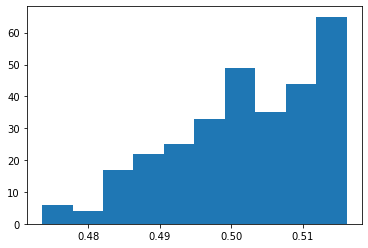

In [71]:
plt.hist(decoded_imgs[:,1])

# Variational autoencoders

In [107]:
normal_1 = minmax_scale(np.random.normal(loc=0, scale=10, size=28*28 * 500)).reshape(500, 28, 28, 1)

In [130]:
normal_1[1, :, :].shape

(28, 28, 1)

In [127]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(normal_1, epochs=300, batch_size=128)

Epoch 1/300


2022-06-16 20:14:14.487686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 1s 57ms/step - loss: 542.1965 - reconstruction_loss: 542.1892 - kl_loss: 1.0431e-06
Epoch 2/300
4/4 [==============================] - 0s 26ms/step - loss: 542.1940 - reconstruction_loss: 542.1846 - kl_loss: 8.4937e-07
Epoch 3/300
4/4 [==============================] - 0s 23ms/step - loss: 542.1751 - reconstruction_loss: 542.1840 - kl_loss: 2.4587e-07
Epoch 4/300
4/4 [==============================] - 0s 24ms/step - loss: 542.1743 - reconstruction_loss: 542.1840 - kl_loss: 5.7369e-07
Epoch 5/300
4/4 [==============================] - 0s 23ms/step - loss: 542.1823 - reconstruction_loss: 542.1827 - kl_loss: 5.0664e-07
Epoch 6/300
4/4 [==============================] - 0s 24ms/step - loss: 542.1886 - reconstruction_loss: 542.1843 - kl_loss: 4.9919e-07
Epoch 7/300
4/4 [==============================] - 0s 24ms/step - loss: 542.1717 - reconstruction_loss: 542.1849 - kl_loss: 4.6194e-07
Epoch 8/300
4/4 [==============================] - 0s 23ms/step - l

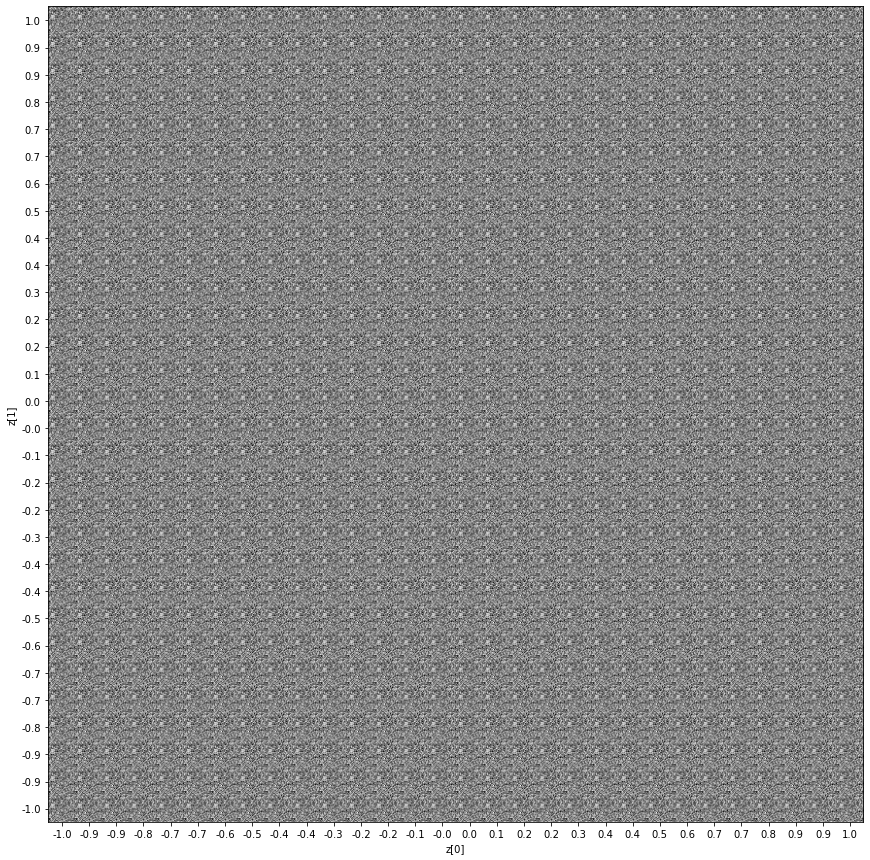

In [128]:
plot_latent_space(vae)